In [343]:
import pandas as pd
from pandas_datareader import data
import numpy as np
from datetime import datetime
from datetime import timedelta
import re
import math
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [4]:
tickers = ['CERN','ETFC','FAST','GRMN','ILMN','ROST',
          'VRTX','WLTW','CHTR','CTXS','NFLX']

columns = ['transaction_date', 'transaction_type', 'company_name',
           'ticker', 'name', 'position', 'shares_traded', 'avg_price',
           'total_price', 'shares_owned', 'own_type']



In [278]:


dict_insiders = {ticker:pd.read_csv('insiders_{}.csv'.format(ticker),header=None,names=columns) for ticker in tickers}
dict_insiders.keys()



dict_keys(['CERN', 'ETFC', 'FAST', 'GRMN', 'ILMN', 'ROST', 'VRTX', 'WLTW', 'CHTR', 'CTXS', 'NFLX'])

### cleaning insiders dictionary 

In [269]:

def clean_dict(x_dict):
    
    for ticker in x_dict.keys():
        df = x_dict[ticker]
    
        df.transaction_type = [item.split('(')[0] for item in df.transaction_type.tolist()]
    
        df.index = pd.to_datetime(df.transaction_date)
    
        df = df.drop('transaction_date',axis=1)
    
        transactions_list = df.transaction_type.tolist()
    
        df['sale_num'] = [1 if item == 'Sale' else 0 for item in transactions_list]
        df['buy_num'] = [1 if item == 'Purchase' else 0 for item in transactions_list]

        weekly = df.set_index(df.index-timedelta(days=7)).resample('W-SUN')
    
        shares_sum = weekly.shares_traded.sum()
        total_price = weekly.total_price.sum()
        insider_sell = weekly.sale_num.sum()
        insider_buy = weekly.buy_num.sum()
    
        left = pd.merge(shares_sum,total_price,on=shares_sum.index)
        right = pd.merge(insider_sell,insider_buy,on=insider_sell.index)

        left = left.set_index('key_0')
        right = right.set_index('key_0')

        agg = pd.merge(left,right,on=left.index)
        agg = agg.set_index('key_0')
        agg.index.name = 'Date'
    
        x_dict[ticker] = agg
    
    

In [294]:
# clean_dict(dict_insiders)


str(dict_insiders['CHTR'].index[-1]).split()[0]


'2019-06-16'

### cleaning stock price data

In [321]:
def get_stocks(x_dict):
    stocks_dict = {}
    
    for item in x_dict.keys():
        ticker = item
        start_date = str(dict_insiders[ticker].index[0]).split()[0]
        end_date = str(dict_insiders[ticker].index[-1]).split()[0]
        
        stocks_df = data.DataReader(ticker,'yahoo',start_date,end_date)
        
        stocks_dict[ticker]=stocks_df
        
    return stocks_dict
        
        

In [331]:
def clean_stocks(x_dict):    
    stocks_dict = {}
    
    for item in x_dict.keys():
        ticker = item
        stocks_df = x_dict[ticker]
        stocks_df['Return'] = stocks_df['Adj Close'].diff()
        stocks_df['Log_Return'] = [math.log(item) for item in stocks_df['Adj Close'].tolist()]
        stocks_df['Log_Return'] = stocks_df['Log_Return'].diff()
        
        stocks_df_weekly = stocks_df.set_index(stocks_df.index-timedelta(days=7)).resample('W-SUN').sum()[['Volume','Return','Log_Return']]
        
        stocks_dict[ticker]=stocks_df_weekly
        
    return stocks_dict

In [323]:
stocks_dict_pre = get_stocks(dict_insiders)

In [332]:
stocks_dict = clean_stocks(stocks_dict_pre)

dict_keys(['CERN', 'ETFC', 'FAST', 'GRMN', 'ILMN', 'ROST', 'VRTX', 'WLTW', 'CHTR', 'CTXS', 'NFLX'])

#### merging and cleaning insider & stock data

In [307]:
def merge_dicts(x_dict,y_dict):
    full_dict = {}
    
    for item in x_dict.keys():
        ticker = item
        
        if ticker not in y_dict.keys():
            raise ValueError('Keys must match in both dictionaries.')
        else:
            
            left = x_dict[ticker]
            right = y_dict[ticker]
            
            full_df = pd.merge(left,right, on=left.index)
            full_df = full_df.set_index('key_0')
            full_df.index.name = 'Date'
            
            full_df.sale_num[full_df.sale_num > 0] = 1
            full_df.buy_num[full_df.buy_num>0] = 1
            full_df['return_dummy'] = full_df.Log_Return
            full_df.return_dummy[full_df.return_dummy<0]=0
            full_df.return_dummy[full_df.return_dummy>0]=1
        
            full_dict[ticker]=full_df
            
    return full_dict
        
        
        

In [334]:
full_dict = merge_dicts(dict_insiders,stocks_dict)

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is tr

### plotting insider trades

In [347]:

def plot_dict(insider_dict,stocks_dict):
    
    for item in insider_dict.keys():
        
        ticker = item
        
        if ticker not in stocks_dict.keys():
            
            raise ValueError('Keys must match in both dictionaries')
            
        else:
            
            stock_df = stocks_dict[ticker]
            insider_df = insider_dict[ticker]
            
            sns.lineplot(x=stock_df.index,y=stock_df['Adj Close'])
            for x in insider_df.index.tolist():
                plt.axvline(x,linestyle='--',linewidth=0.1,c='b')
                    
        

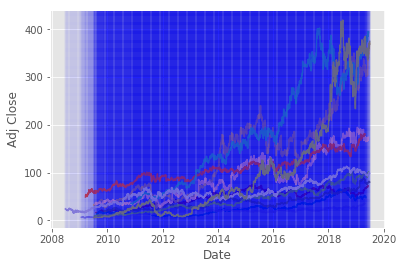

In [348]:
plot_dict(dict_insiders,stocks_dict_pre)

### fitting logistic models

In [354]:
def logit_dict(x_dict):
    fit_dict = {}
    
    for item in x_dict.keys():
        
        ticker = item
        print(ticker)
        df = x_dict[ticker]
        
        X = df[['shares_traded','sale_num','buy_num']]
        Y = df.return_dummy
        logit_model = sm.Logit(Y,X)
        result = logit_model.fit()
        
        fit_dict[ticker]=result.summary2()
        
        
    return fit_dict

In [364]:
models_dict = logit_dict(full_dict)


CERN
Optimization terminated successfully.
         Current function value: 0.690904
         Iterations 4
ETFC
Optimization terminated successfully.
         Current function value: 0.689647
         Iterations 6
FAST
Optimization terminated successfully.
         Current function value: 0.683172
         Iterations 4
GRMN
         Current function value: 0.688239
         Iterations: 35
ILMN
Optimization terminated successfully.
         Current function value: 0.682538
         Iterations 20
WLTW
Optimization terminated successfully.
         Current function value: 0.687934
         Iterations 5
CHTR
Optimization terminated successfully.
         Current function value: 0.689260
         Iterations 6
CTXS
Optimization terminated successfully.
         Current function value: 0.689543
         Iterations 4
NFLX
Optimization terminated successfully.
         Current function value: 0.685759
         Iterations 5


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [370]:
for key,value in models_dict.items():
    print(key)
    print('-'*30)
    print(value)
    print('*'*30)

CERN
------------------------------
                        Results: Logit
Model:              Logit            Pseudo R-squared: -0.001  
Dependent Variable: return_dummy     AIC:              717.6309
Date:               2019-07-08 19:33 BIC:              730.3634
No. Observations:   515              Log-Likelihood:   -355.82 
Df Model:           2                LL-Null:          -355.34 
Df Residuals:       512              LLR p-value:      1.0000  
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     4.0000                                     
----------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|    [0.025  0.975]
----------------------------------------------------------------
shares_traded  0.0000    0.0000  0.5611  0.5747  -0.0000  0.0000
sale_num       0.1554    0.2153  0.7218  0.4704  -0.2665  0.5773
buy_num        0.6294    1.2270  0.5129  0.6080  -1.7756  3.0344

**********************